#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from PIL import Image, ImageFilter
import imghdr
from os import listdir
from os.path import isfile, join

### Dowlining Data

In [ ]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [3]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/AFLW2000-3D.zip

unzip:  cannot find or open /content/drive/MyDrive/AFLW2000-3D.zip, /content/drive/MyDrive/AFLW2000-3D.zip.zip or /content/drive/MyDrive/AFLW2000-3D.zip.ZIP.


In [6]:
mylist = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.jpg")]
mylist

['image00972',
 'image04180',
 'image01086',
 'image00334',
 'image03075',
 'image00862',
 'image03026',
 'image00527',
 'image00726',
 'image00960',
 'image01469',
 'image00545',
 'image02592',
 'image00122',
 'image01163',
 'image03926',
 'image00082',
 'image03892',
 'image02295',
 'image03453',
 'image02073',
 'image02030',
 'image01773',
 'image00329',
 'image02080',
 'image01472',
 'image02332',
 'image01785',
 'image02038',
 'image02544',
 'image03835',
 'image02054',
 'image03624',
 'image00036',
 'image02034',
 'image01329',
 'image03791',
 'image03984',
 'image01087',
 'image02769',
 'image00734',
 'image03908',
 'image03765',
 'image00360',
 'image02739',
 'image02513',
 'image03270',
 'image04062',
 'image03977',
 'image01346',
 'image00294',
 'image03013',
 'image01762',
 'image00753',
 'image00826',
 'image02803',
 'image02996',
 'image02494',
 'image02310',
 'image00352',
 'image01202',
 'image04248',
 'image02846',
 'image00391',
 'image01300',
 'image03800',
 'image006

In [7]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines


In [8]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [9]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

In [10]:
class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        print(img)
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)
        

        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)
        #print("pt2d",pt2d)
       # print("pt2d shape",pt2d.shape)


        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]

        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return cont_labels

    def __len__(self):
        # 2,000
        return self.length



    #my_func    
    def getitem3(self, index,image_mode='RGB'):
        ## index jpg inamge
        ##mat_path .mat image
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)

        # Crop the face loosely
        pt3d = get_pt3d_from_mat(mat_path)

        x_min = min(pt3d[0,:])
        y_min = min(pt3d[1,:])
        x_max = max(pt3d[0,:])
        y_max = max(pt3d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        #bins = np.array(range(-99, 102, 3))
       #labels =np.digitize([yaw, pitch, roll], bins) - 1
        labels = [yaw, pitch, roll]
        x, y = pt3d[0,:],pt3d[1,:]
        # if transform is not None:
        #     img = transform(img)

        return x,y, labels
    






In [11]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

In [12]:
all_images = mylist
all_points_x = []
all_points_y = []
angels = []
faceModule = mediapipe.solutions.face_mesh
for img in (all_images):
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
    image = cv2.imread('/content/AFLW2000/'+img+'.jpg')
        # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      x_img = []
      y_img = []
      face = results.multi_face_landmarks[0] 
      # looping over the face points
      for  landmark in (face.landmark):
          x = landmark.x
          y = landmark.y
          # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
          shape = image.shape 
          relative_x = int(x * shape[1])
          relative_y = int(y * shape[0])
          x_img.append(relative_x)
          y_img.append(relative_y)
      all_points_x.append(x_img)
      all_points_y.append(y_img)
      mat_file = sio.loadmat('/content/AFLW2000/'+img+'.mat')
      # extracting the labels 3 angels
      pose_para = mat_file["Pose_Para"][0][:3]
      # appending the 3 angels to labels list
      angels.append(pose_para)


# Checking how many images Mediapipe actually captuerd

In [13]:
print(len(all_points_x))


1853


# Stacking points into array

In [14]:
all_points_x = np.array(all_points_x)
all_points_y = np.array(all_points_y)
all_points_x.shape

(1853, 468)

# Centering the points at index 99

In [15]:
all_points_x = all_points_x - all_points_x[:,99].reshape(-1,1)
all_points_y = all_points_y - all_points_y[:,99].reshape(-1,1)

# Choosing the distance between 2 random points and divide all points by that distance

In [16]:
x300, y300 = all_points_x[:, 300],all_points_y[:, 300]
x131, y131 = all_points_x[:, 131],all_points_y[:, 131]
dist = np.linalg.norm(np.array((x300, y300)) - np.array((x131, y131)),axis = 0).reshape(-1,1)

featuers_x = all_points_x / dist
featuers_y = all_points_y / dist

In [17]:
featuers = np.hstack((featuers_x, featuers_y))

In [18]:
featuers.shape

(1853, 936)

In [19]:
featuers

array([[ 0.08995138,  0.06746354,  0.08245543, ..., -0.44226097,
        -0.53221235, -0.5547002 ],
       [ 0.04808414, -0.08242995,  0.04121497, ..., -0.43962639,
        -0.54953299, -0.61135545],
       [ 0.10459527,  0.08498366,  0.09152086, ..., -0.47067872,
        -0.62757163, -0.65372045],
       ...,
       [ 0.05941864,  0.23767456,  0.10695355, ..., -0.55853522,
        -0.68925622, -0.73679114],
       [-0.02572479,  0.01714986,  0.04287465, ..., -0.28297267,
        -0.18864844, -0.2057983 ],
       [ 0.20261844,  0.25890134,  0.1688487 , ..., -0.54031584,
        -0.55157242, -0.59659874]])

In [20]:
# Preparing the angles
labels = np.zeros((1853, 3))
for i in range(len(angels)):
  labels[i,:] = angels[i]


In [21]:
labels.shape

(1853, 3)

In [22]:
labels

array([[ 0.075391  ,  0.06628842, -0.07607973],
       [-0.51412052,  0.75234222, -0.34148681],
       [-0.34731895, -0.02775929, -0.09128705],
       ...,
       [-0.53795624, -0.47879195,  0.25495899],
       [ 0.28218687,  0.60487312,  0.47403568],
       [ 0.38623983, -0.32851034, -0.10940092]])

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X, y_yaw = featuers, labels[:,1]
X, y_pitch = featuers, labels[:,0]
X, y_roll = featuers, labels[:,2]

In [25]:
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw =train_test_split(X, y_yaw, random_state = 1) 
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch =train_test_split(X, y_pitch, random_state = 1) 
X_train_roll, X_test_roll, y_train_roll, y_test_roll =train_test_split(X, y_roll, random_state = 1) 

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve


# Cross Validtion for the three angels to know which model is the best between SVR & XGBRegressor

In [ ]:
train_scores, valid_scores = validation_curve(
     SVR(), X_train_yaw, y_train_yaw, param_name="C", param_range=[100, 200, 300],
    cv=5)
print(f"for yaw:{train_scores}")
print(f"for yaw:{valid_scores}")
train_scores, valid_scores = validation_curve(
     SVR(), X_train_pitch, y_train_pitch, param_name="C", param_range=[100, 200, 300],
    cv=5)
print(f"for pitch:{train_scores}")
print(f"for pitch:{valid_scores}")
train_scores, valid_scores = validation_curve(
     SVR(), X_train_roll, y_train_roll, param_name="C", param_range=[100, 200, 300],
    cv=5)
print(f"for roll:{train_scores}")
print(f"for roll:{valid_scores}")

for yaw:[[0.88328035 0.89362469 0.89828194 0.92450203 0.95736033]
 [0.90279295 0.91400656 0.91555695 0.95043847 0.95985105]
 [0.91831809 0.92906348 0.92795701 0.96212122 0.96126696]]
for yaw:[[ 0.94586088  0.96121241  0.90825695  0.64110588  0.65088932]
 [ 0.94184823  0.95775915  0.90456344 -0.04519637  0.6470508 ]
 [ 0.93240529  0.95373591  0.90090408 -1.06550309  0.6466714 ]]
for pitch:[[0.34959187 0.39972364 0.35707104 0.49303842 0.84141935]
 [0.40712504 0.47544273 0.40547368 0.61557713 0.85551401]
 [0.46039269 0.53587759 0.44740763 0.71872342 0.86447406]]
for pitch:[[ 0.65126356  0.70402498  0.62000475 -0.62043259  0.08746624]
 [ 0.60299381  0.66579545  0.58972567 -3.54211393  0.07550122]
 [ 0.53551458  0.63453019  0.555211   -7.82181039  0.07085537]]
for roll:[[0.41467439 0.4639453  0.43106102 0.52090055 0.91391348]
 [0.46281321 0.51045668 0.4753347  0.62433909 0.91787287]
 [0.50411111 0.55246669 0.51285321 0.70660393 0.92110086]]
for roll:[[ 0.82151233  0.80168454  0.79007957  0.

In [ ]:
train_scores, valid_scores = validation_curve(
     xgb.XGBRegressor(), X_train_yaw, y_train_yaw, param_name="C", param_range=[100, 200, 300],
    cv=5)
print(f"for yaw:{train_scores}")
print(f"for yaw:{valid_scores}")



[09:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
train_scores, valid_scores = validation_curve(
     xgb.XGBRegressor(), X_train_pitch, y_train_pitch, param_name="C", param_range=[100, 200, 300],
    cv=5)
print(f"for pitch:{train_scores}")
print(f"for pitch:{valid_scores}")

[09:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
train_scores, valid_scores = validation_curve(
     xgb.XGBRegressor(), X_train_roll, y_train_roll, param_name="C", param_range=[100, 200, 300],
    cv=5)
print(f"for roll:{train_scores}")
print(f"for roll:{valid_scores}")

[09:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# Fitting the best models and observing their MAE


In [28]:
best_model_yaw = SVR(kernel = 'poly', C=100).fit(X_train_yaw, y_train_yaw)
yp = best_model_yaw.predict(X_test_yaw)
mean_absolute_error(y_test_yaw, yp)

0.06825412462448756

In [29]:
best_model_pitch = SVR(kernel = 'poly', C=100).fit(X_train_pitch, y_train_pitch)
yp = best_model_pitch.predict(X_test_pitch)
mean_absolute_error(y_test_pitch, yp)

0.09264461060332531

In [30]:
best_model_roll = xgb.XGBRegressor(reg_lambda = 100).fit(X_train_roll, y_train_roll)
yp = best_model_roll.predict(X_test_roll)
mean_absolute_error(y_test_roll, yp)

[05:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.06425137726110906

# Orgininal Axis

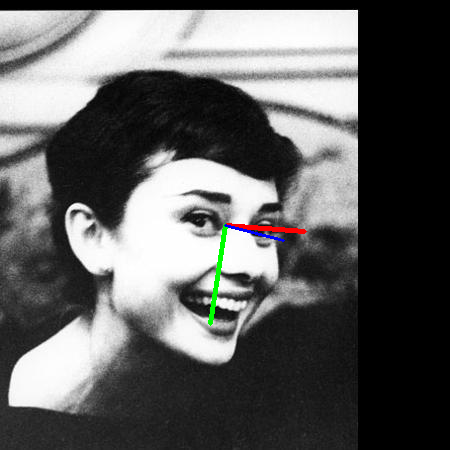

-0.6289137 -0.19141869 0.18062863


In [31]:
image = cv2.imread('/content/AFLW2000/'+'image00725'+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+'image00725'+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))
print(yaw, pitch, roll)

# Predicted Axis

image01845
[-0.57607459]
[-0.1197075]
[0.20596376]


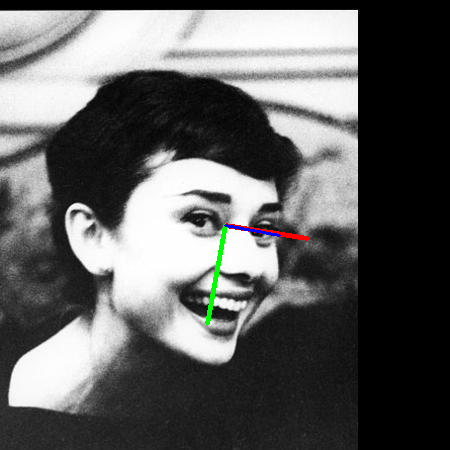

In [32]:
test_xpts =[]
test_ypts = []
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
  # loading the image
      image = cv2.imread('/content/AFLW2000/'+"image00725"+'.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        x_img = []
        y_img = []
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for  landmark in (face.landmark):
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                x_img.append(relative_x)
                y_img.append(relative_y)
      test_xpts.append(x_img)
      test_ypts.append(y_img)
      test_xpts = np.array(test_xpts)
      test_ypts = np.array(test_ypts)
      test_xpts = test_xpts - test_xpts[:,99].reshape(-1,1)
      test_ypts = test_ypts - test_ypts[:,99].reshape(-1,1)
      
      x300, y300 = test_xpts[:, 300],test_ypts[:, 300]
      x131, y131 = test_xpts[:, 131],test_ypts[:, 131]
      dist = np.linalg.norm(np.array((x300, y300)) - np.array((x131, y131)),axis = 0).reshape(-1,1)

      featuers_x = test_xpts / dist
      featuers_y = test_ypts / dist
      featuers = np.hstack((featuers_x, featuers_y)).reshape(936,)
      print(img)
      yaw_predict = best_model_yaw.predict([featuers])
      print(yaw_predict)
      pitch_predict = best_model_pitch.predict([featuers])
      print(pitch_predict)
      roll_predict = best_model_roll.predict([featuers])
      print(roll_predict)
      cv2_imshow(draw_axis(image,pitch_predict,yaw_predict,roll_predict))


In [50]:
import cv2
from google.colab import files 
from queue import Queue
from statistics import mean
# Opens the inbuilt camera of laptop to capture video.
vid = cv2.VideoCapture('/content/drive/MyDrive/WIN_20220617_07_21_41_Pro.mp4')
width= int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
currentframe = 0
all_frames = []


#Creating queues of angels to take averge of them at drawing
size = 50
pitch_queue = Queue(maxsize = size)
yaw_queue = Queue(maxsize = size)
roll_queue = Queue(maxsize = size)
while (True):

    # reading from frame
    success, image = vid.read()
    if success:
      with faceModule.FaceMesh(static_image_mode=True) as faces:
  # loading the image
      # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          x_img = []
          y_img = []
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              for  landmark in (face.landmark):
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  x_img.append(relative_x)
                  y_img.append(relative_y)
        x_img = np.array(x_img)
        y_img = np.array(y_img)
        # Centering the data at index 99
        x_img = x_img - x_img[99]
        y_img = y_img - y_img[99]
        # Choosing the distance between 2 random points and divide all points by that distance
        x300, y300 = x_img[300],y_img[300]
        x131, y131 = x_img[131],y_img[131]
        dist = np.linalg.norm(np.array((x300, y300)) - np.array((x131, y131)),axis = 0).reshape(-1,1)
        featuers_x = x_img / dist
        featuers_y = y_img / dist
        featuers = np.hstack((featuers_x, featuers_y)).reshape(936,)
        if (pitch_queue.full()):
                pitch_queue.get()
                roll_queue.get()
                yaw_queue.get()
        yaw_predict = best_model_yaw.predict([featuers])
        yaw_queue.put(yaw_predict)
        pitch_predict = best_model_pitch.predict([featuers])
        pitch_queue.put(pitch_predict)
        roll_predict = best_model_roll.predict([featuers])
        roll_queue.put(roll_predict)

        pitch_l = list(pitch_queue.queue)
        yaw_l = list(yaw_queue.queue)
        roll_l = list(roll_queue.queue)

        pitch_mean = sum(pitch_l)/len(pitch_l)
        yaw_mean = sum(yaw_l)/len(yaw_l)
        roll_mean =  sum(roll_l)/len(roll_l)

        predicted_image = draw_axis(image,pitch_mean,yaw_mean,roll_mean, tdx =576 , tdy =360)
        all_frames.append(predicted_image)
        cv2.imwrite('/content/drive/MyDrive/outofframes/' + str(currentframe) + '.jpg' , predicted_image)
          # increasing counter so that it will
        currentframe += 1
    else:
        break

# Release all space and windows once done
vid.release()
cv2.destroyAllWindows()

In [46]:
len(all_frames)

469

In [52]:
# converting the frames to video
output_video = cv2.VideoWriter('output_video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(all_frames)):
    output_video.write(all_frames[i])
output_video.release()

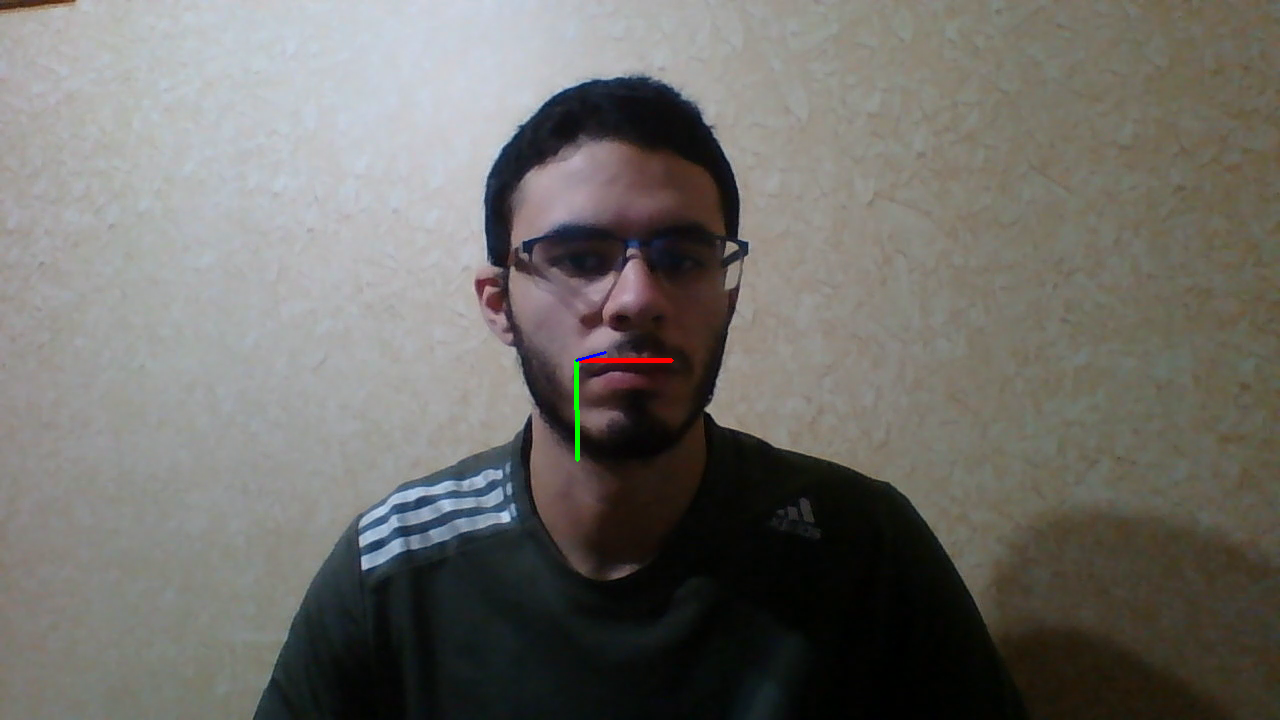

In [51]:
cv2_imshow(all_frames[200])
